# Car Object Detection Using YoloV8

## Installing YoloV8 from Ultralytics

In [1]:
# install yolov8
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 16.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


In [3]:
from ultralytics import YOLO
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
import yaml
import glob
from sklearn.model_selection import train_test_split

from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt
from IPython import display
display.clear_output()
!yolo mode=checks
%matplotlib inline

WARNING ⚠️ 'yolo mode=checks' is deprecated. Use 'yolo checks' instead.
Ultralytics YOLOv8.0.146 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4959.2/8062.4 GB disk)


In [4]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.146 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4959.2/8062.4 GB disk)


## Setting Parameters

In [5]:
DIR = "/kaggle/working/datasets/cars/"
IMAGES = DIR +"images/"
LABELS = DIR +"labels/"

TRAIN = "/kaggle/input/car-object-detection/data/training_images"
TEST = "/kaggle/input/car-object-detection/data/testing_images"

In [6]:
df = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [7]:
! pwd

/kaggle/working


## Setting dataset

In [8]:
files = list(df.image.unique())

files_train, files_valid = train_test_split(files, test_size = 0.2)

In [9]:
# make directories
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [10]:
train_filename = set(files_train)
valid_filename = set(files_valid)
for file in glob.glob(TRAIN+"/*"):
    fname =os.path.basename(file)
    if fname in train_filename:
        sh.copy(file, IMAGES+"train")
    elif fname in valid_filename:
        sh.copy(file, IMAGES+"valid")

In [11]:
%cd /kaggle/working/datasets/cars

/kaggle/working/datasets/cars


In [12]:
for _, row in df.iterrows():    
    image_file = row['image']
    class_id = "0"
    x = row['xmin']
    y = row['ymin']
    width = row['xmax'] - row['xmin']
    height = row['ymax'] - row['ymin']

    x_center = x + (width / 2)
    y_center = y + (height / 2)
    x_center /= 676
    y_center /= 380
    width /= 676
    height /= 380

    if image_file in train_filename:   
        annotation_file = os.path.join(LABELS) + "train/" + image_file.replace('.jpg', '.txt')
    else:
        annotation_file = os.path.join(LABELS) + "valid/" + image_file.replace('.jpg', '.txt')
        
    with open(annotation_file, 'a') as ann_file:
        ann_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

## Creating yaml file

In [13]:
%%writefile dataset.yaml
# Path
path: ./cars
train: images/train
val: images/valid

# Class
nc: 1
# name of class    
names: ['car']

Writing dataset.yaml


In [14]:
!ls /kaggle/working/datasets/cars

dataset.yaml  images  labels


## Training the Model from scratch

In [15]:
model = YOLO()
model.train(data="/kaggle/working/datasets/cars/dataset.yaml", epochs=50) # train the model

#model = YOLO("yolov8m.pt") #load a pretrained YOLOv8m model

100%|██████████| 6.23M/6.23M [00:00<00:00, 77.0MB/s]
Ultralytics YOLOv8.0.146 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/datasets/cars/dataset.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tru

In [16]:
!ls /kaggle/working/datasets/cars/runs/detect/train

F1_curve.png					  train_batch1.jpg
PR_curve.png					  train_batch2.jpg
P_curve.png					  train_batch720.jpg
R_curve.png					  train_batch721.jpg
args.yaml					  train_batch722.jpg
confusion_matrix.png				  val_batch0_labels.jpg
confusion_matrix_normalized.png			  val_batch0_pred.jpg
events.out.tfevents.1690993695.adef6501af21.29.0  val_batch1_labels.jpg
labels.jpg					  val_batch1_pred.jpg
labels_correlogram.jpg				  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


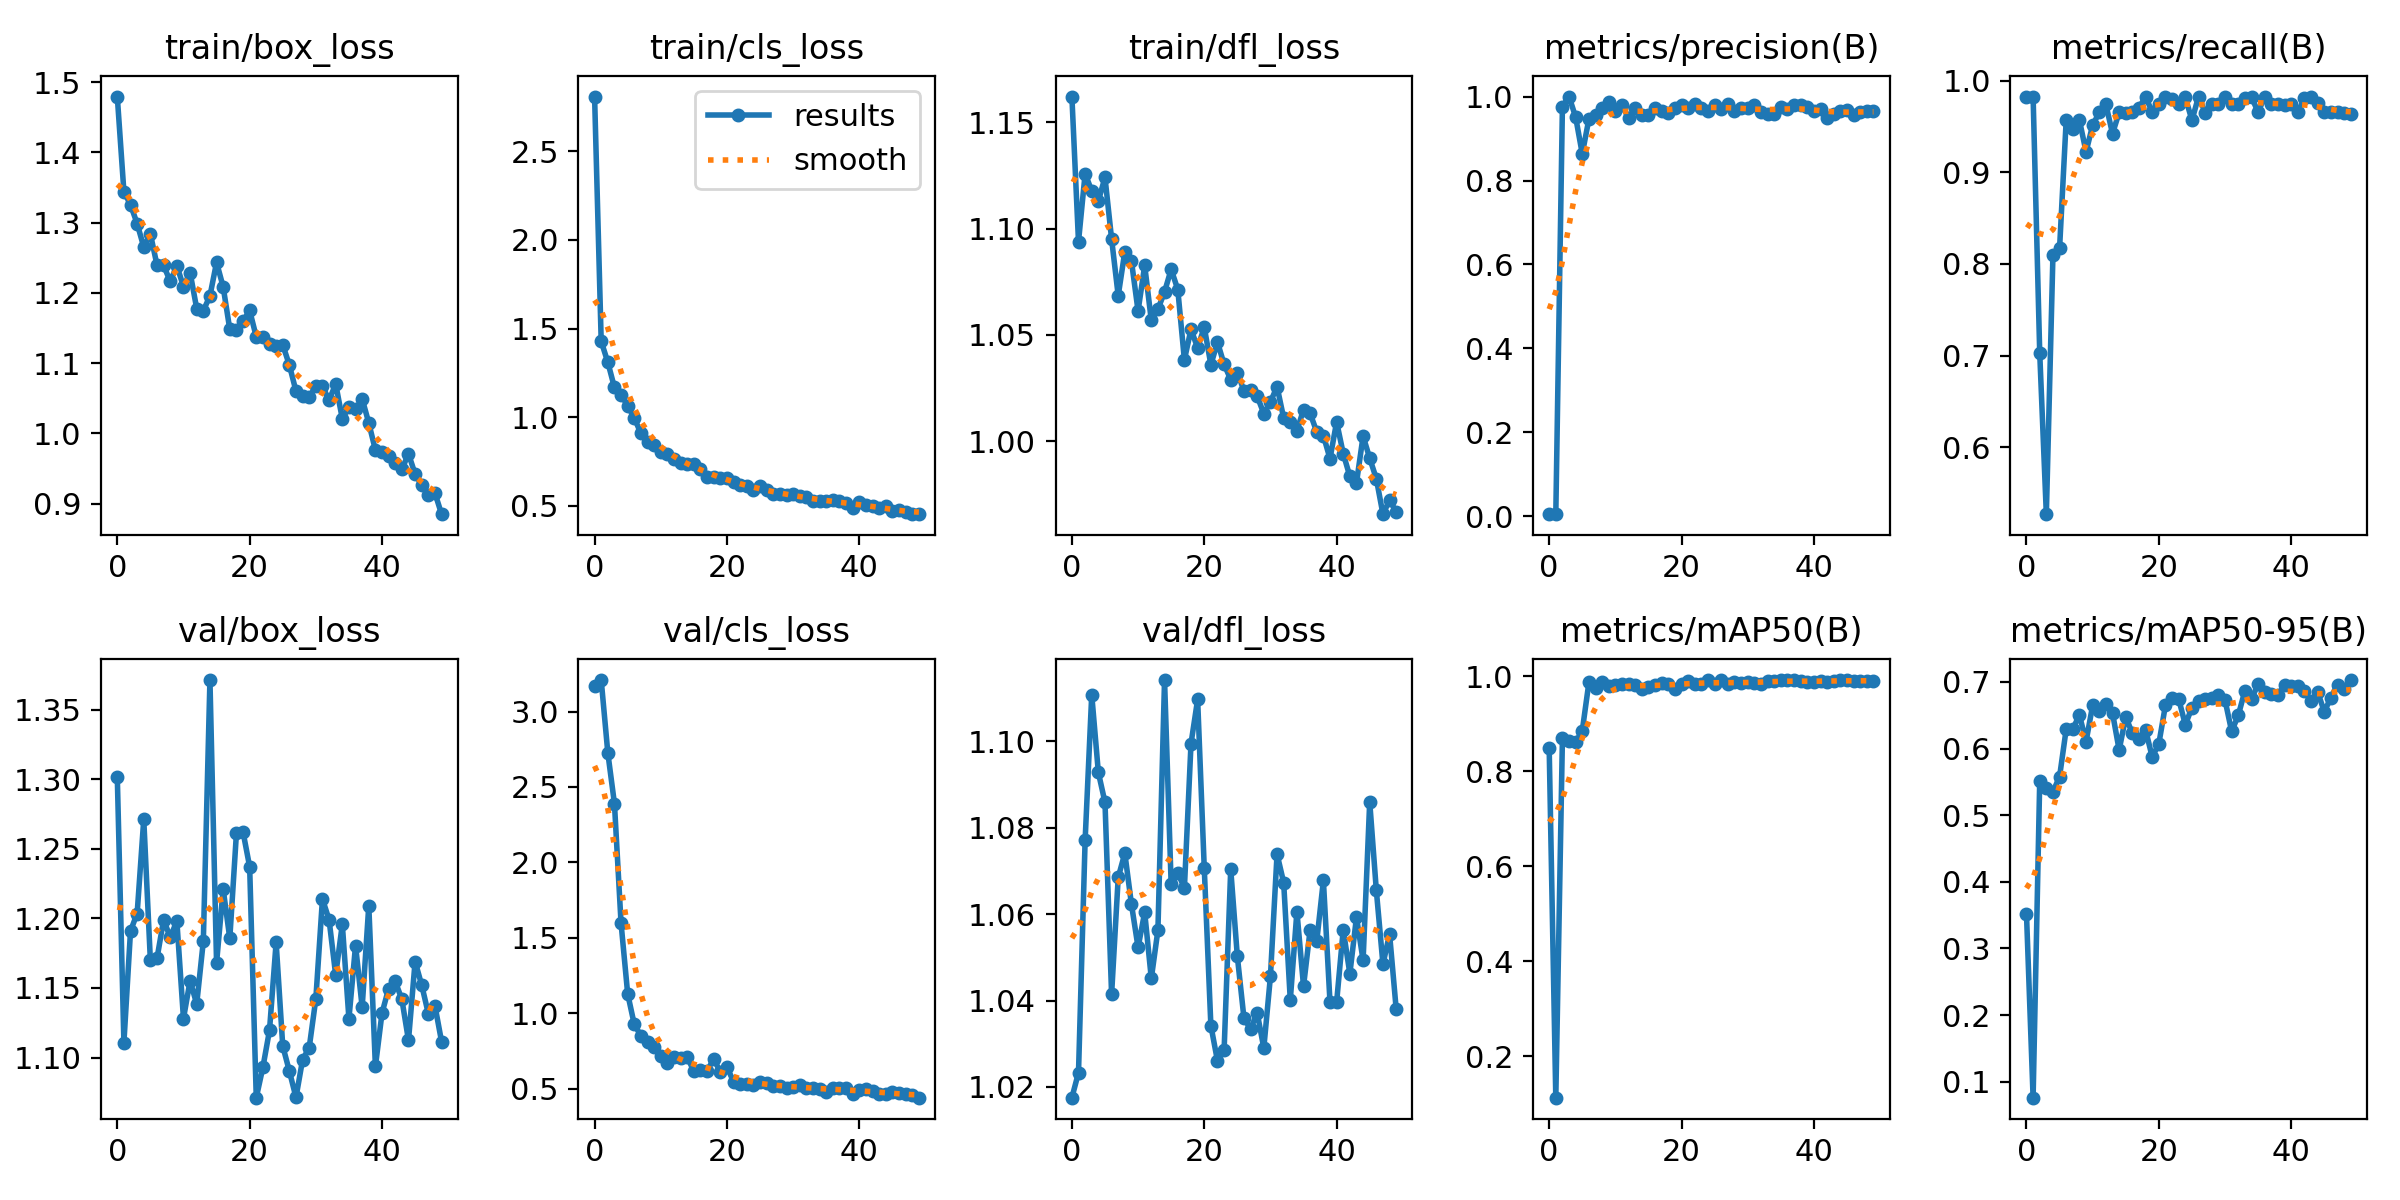

In [20]:
Image(filename=f"/kaggle/working/datasets/cars/runs/detect/train/results.png", width=1200)

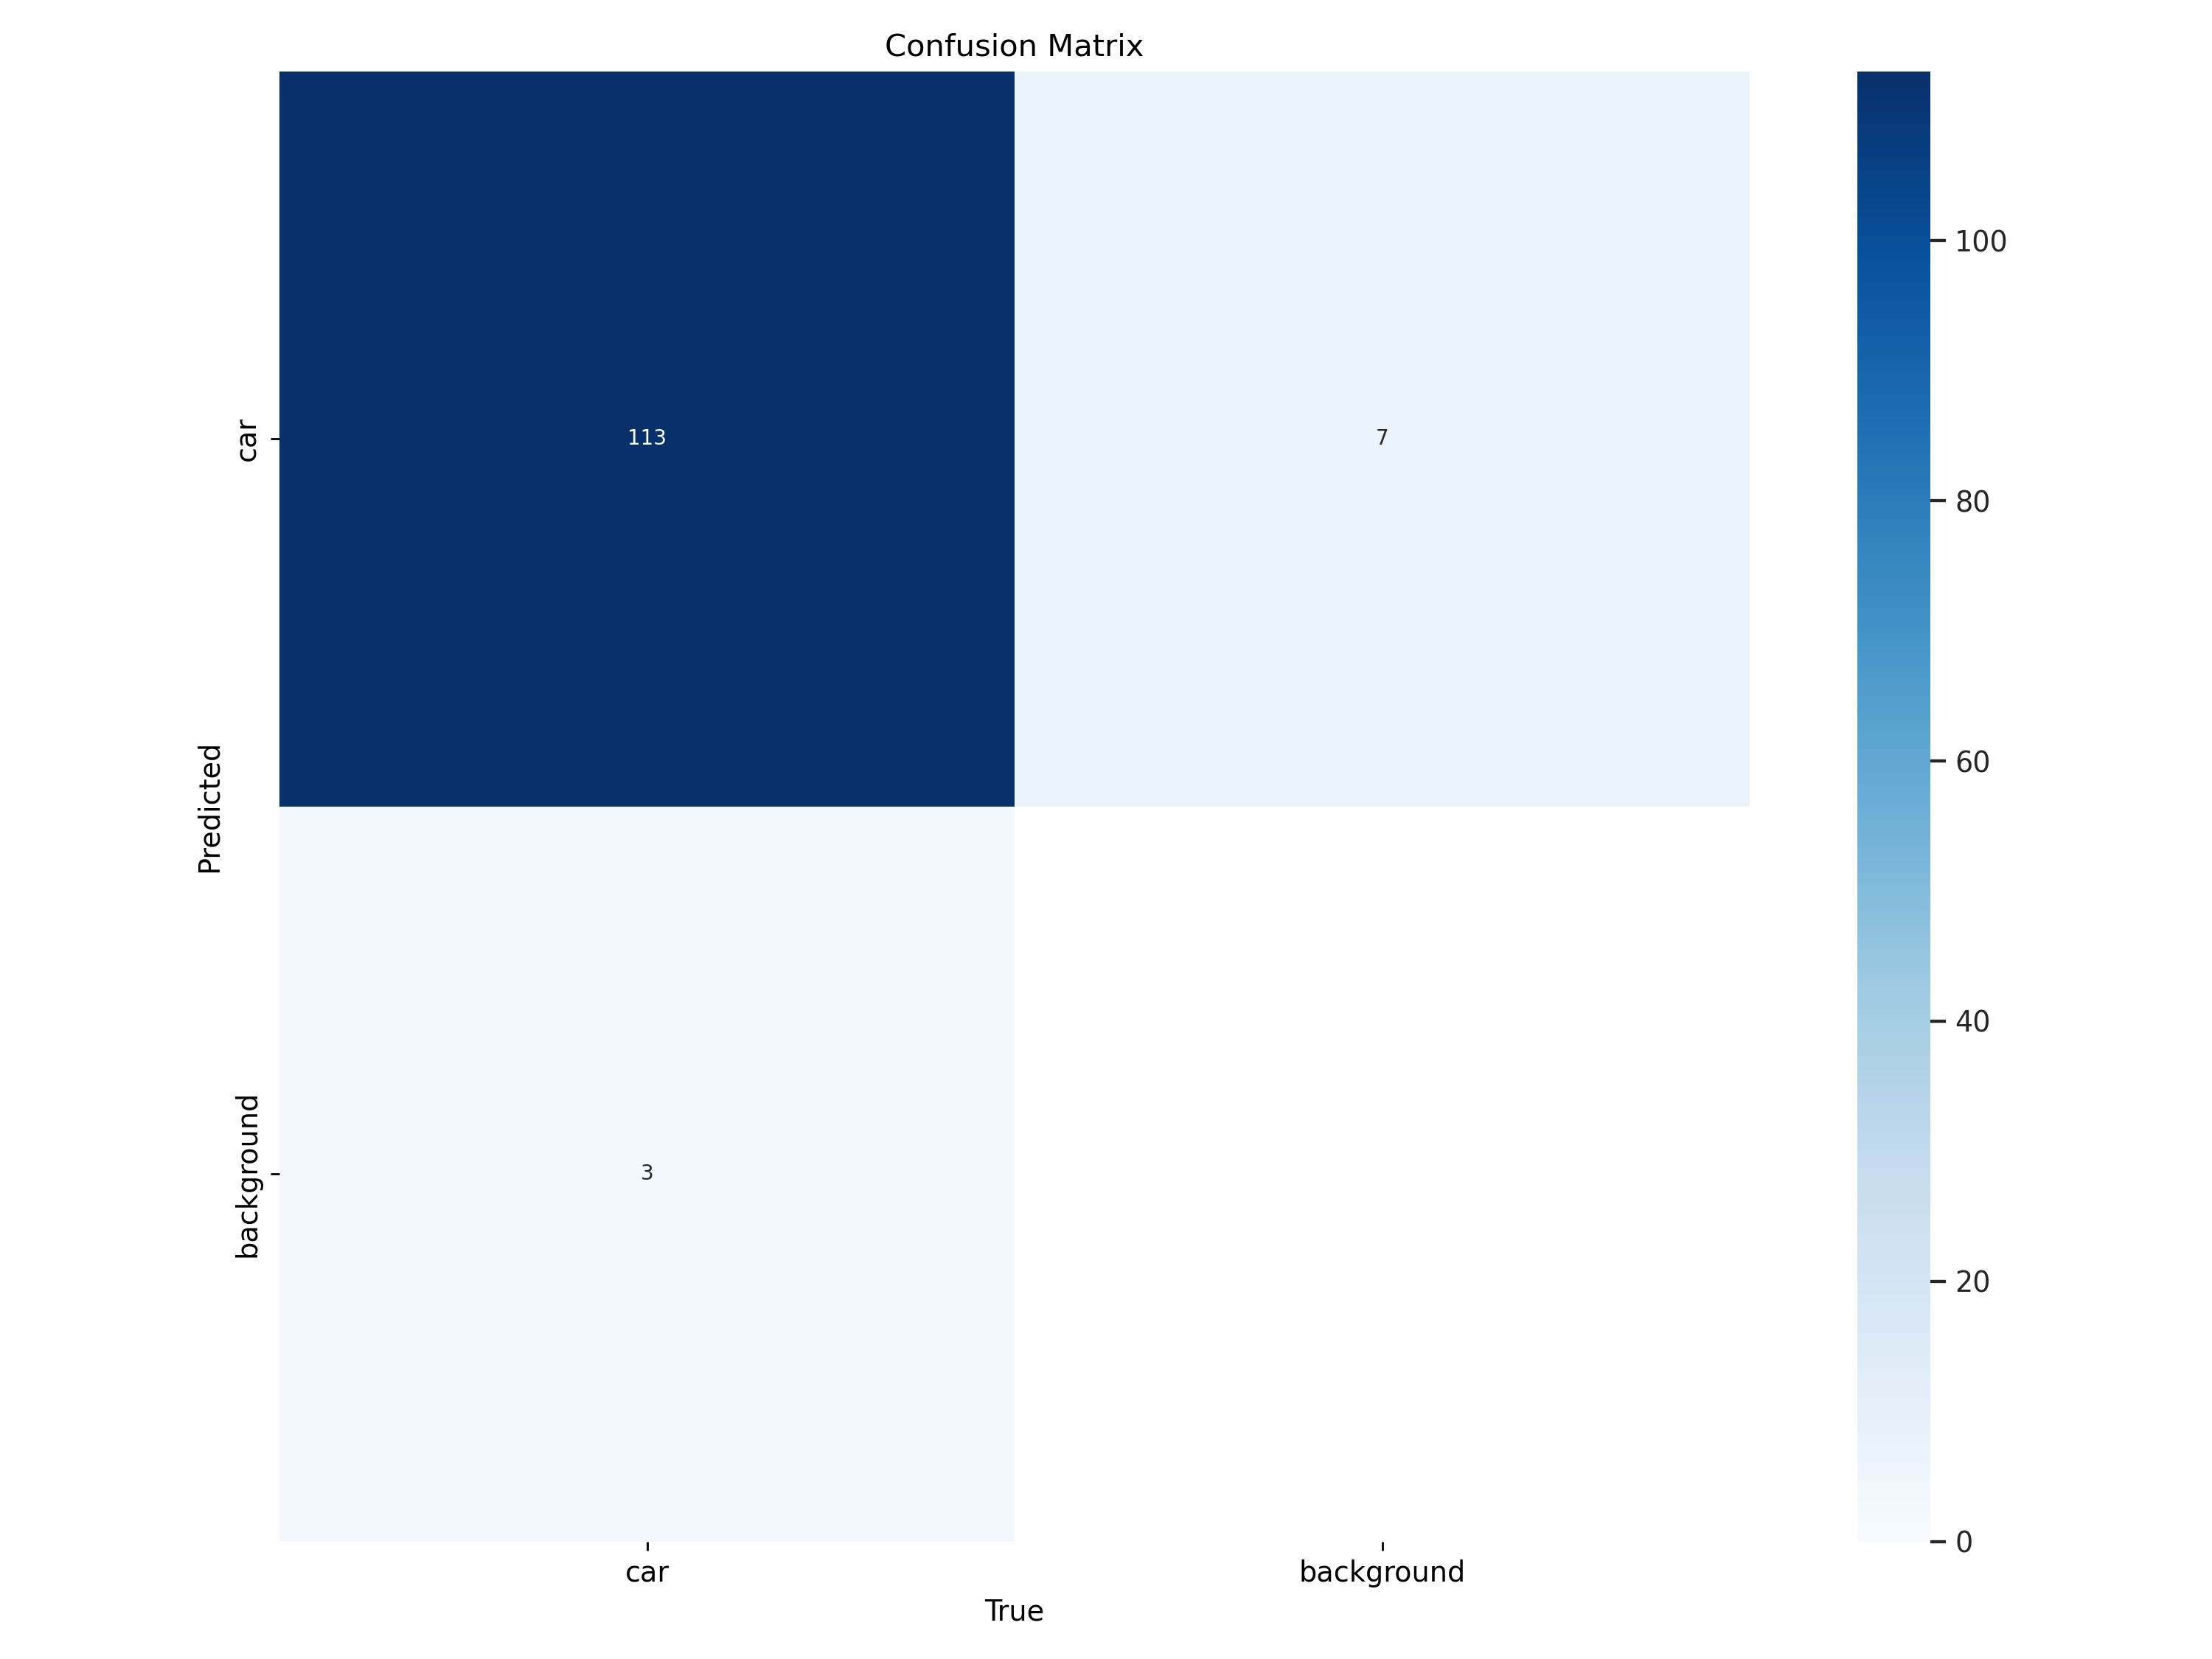

In [21]:
Image(filename=f"/kaggle/working/datasets/cars/runs/detect/train/confusion_matrix.png", width=800)

## Validate the model

In [22]:
!yolo task=detect mode=val model=/kaggle/working/datasets/cars/runs/detect/train/weights/best.pt data=dataset.yaml

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [23]:
!ls /kaggle/working/datasets/cars/runs/detect/val

F1_curve.png  confusion_matrix.png	       val_batch1_labels.jpg
PR_curve.png  confusion_matrix_normalized.png  val_batch1_pred.jpg
P_curve.png   val_batch0_labels.jpg	       val_batch2_labels.jpg
R_curve.png   val_batch0_pred.jpg	       val_batch2_pred.jpg


## Model Prediction on Validation Batch

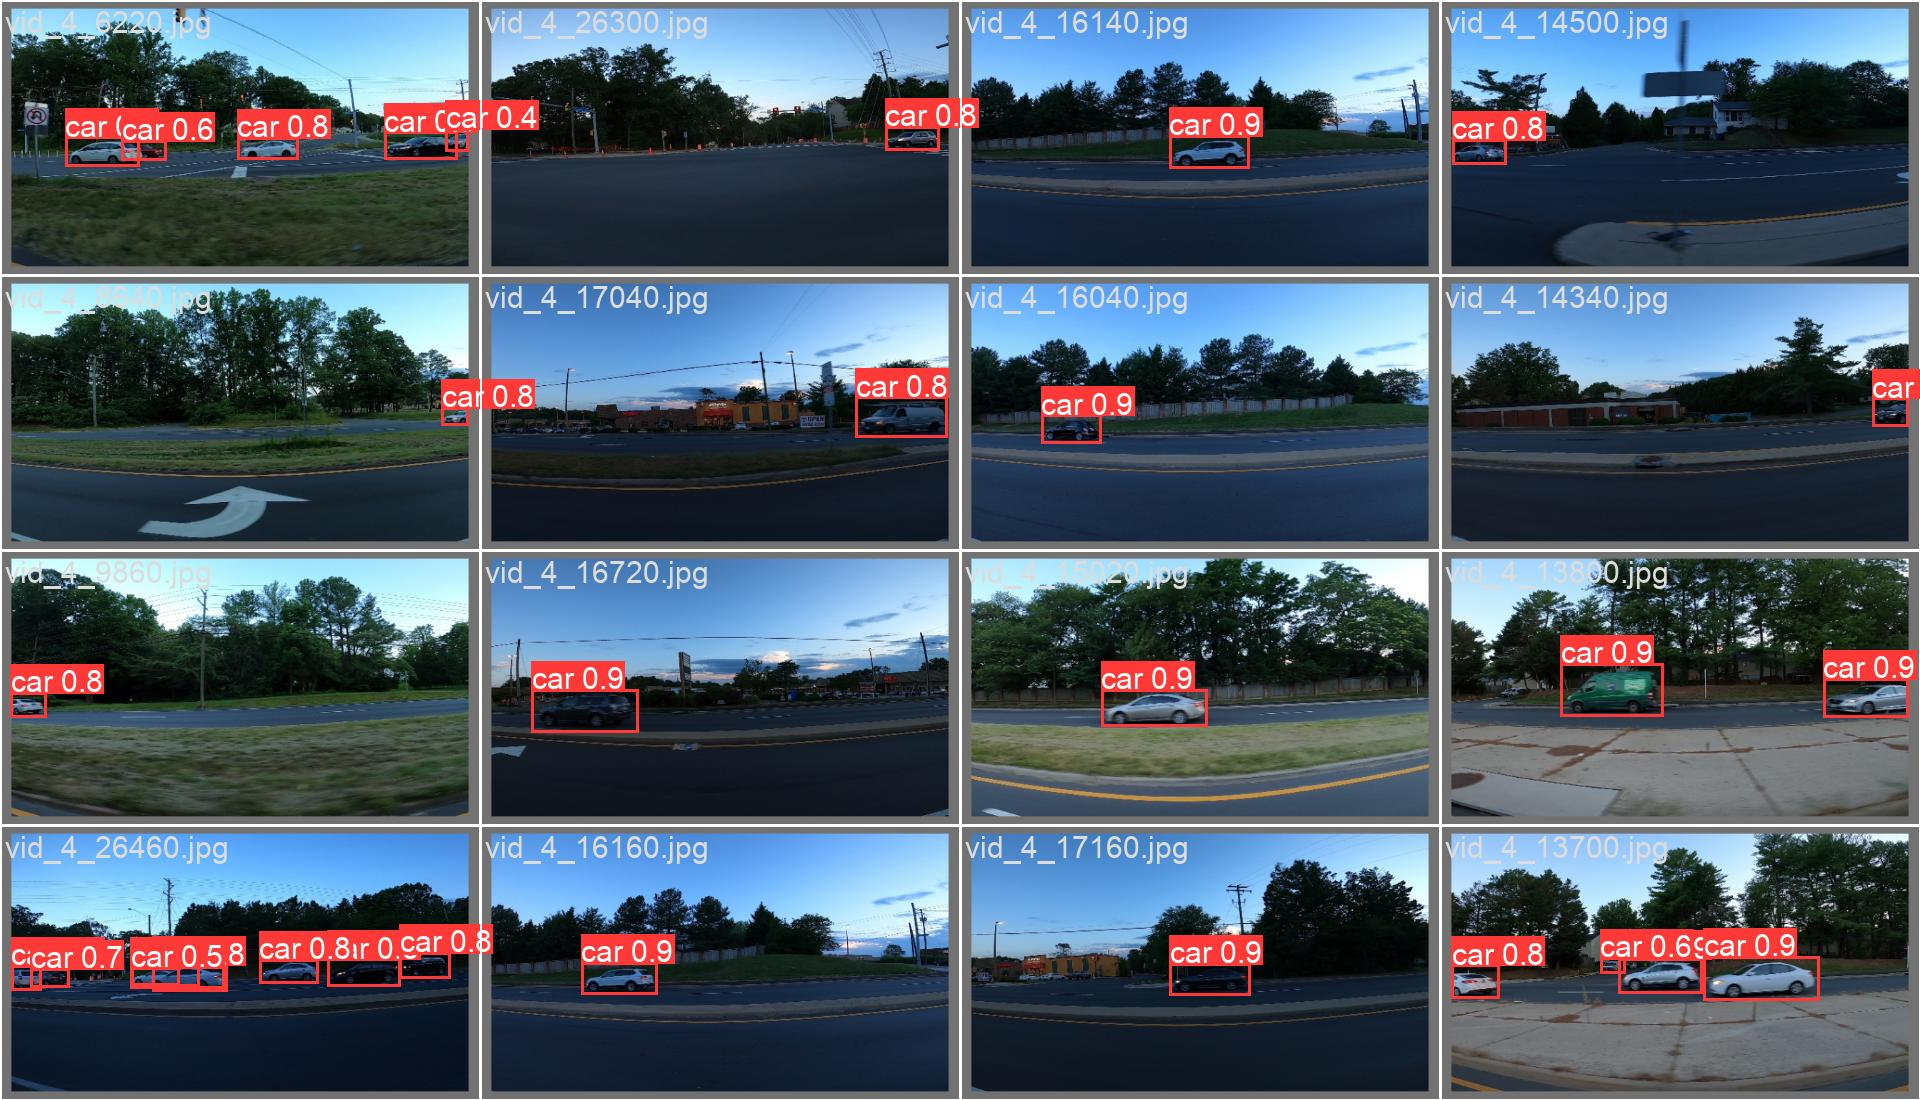

In [26]:
Image(filename=f"/kaggle/working/datasets/cars/runs/detect/val/val_batch2_pred.jpg", width=1200)

## Prediction on the Custom Model

In [32]:
#Predicting data using a custom model
!yolo task=detect mode=predict model=/kaggle/working/datasets/cars/runs/detect/train/weights/best.pt conf=0.5 source=/kaggle/input/car-object-detection/data/testing_images

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

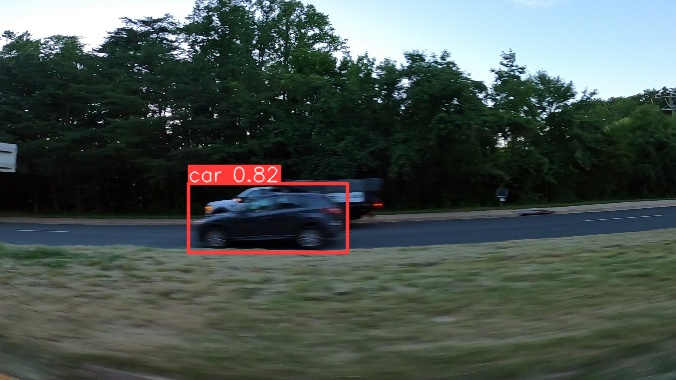

In [38]:
Image(filename=f"/kaggle/working/datasets/cars/runs/detect/predict/vid_5_26660.jpg", width=600)

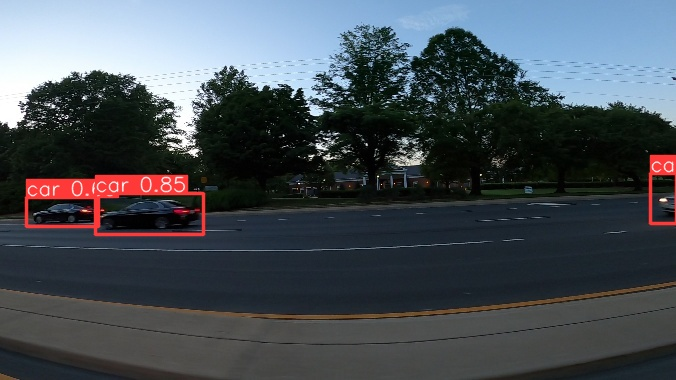

In [34]:
Image(filename=f"/kaggle/working/datasets/cars/runs/detect/predict/vid_5_31040.jpg", width=600)

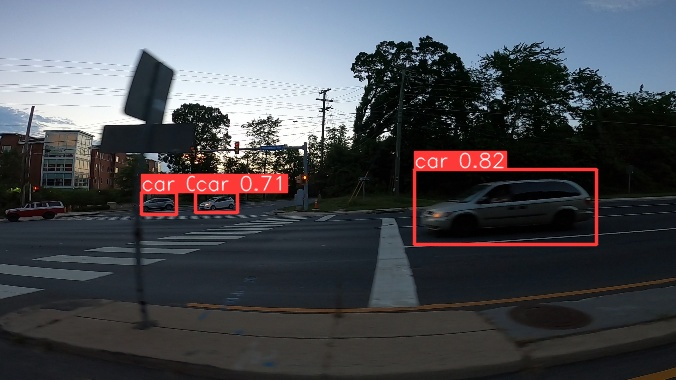

In [35]:
Image(filename=f"/kaggle/working/datasets/cars/runs/detect/predict/vid_5_27480.jpg", width=600)

In [39]:
#Predicting data using a custom model
!yolo task=detect mode=predict model=/kaggle/working/datasets/cars/runs/detect/train/weights/best.pt conf=0.5 source=/kaggle/input/car-videos/car_video1.mp4

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [40]:
from IPython.display import Video

avi_video_path = 'kaggle/working/datasets/cars/runs/detect/predict4/car_video1.avi'
Video(avi_video_path, embed=True)

In [43]:
#Predicting data using a custom model
!yolo task=detect mode=predict model=/kaggle/working/datasets/cars/runs/detect/train/weights/best.pt conf=0.5 source=/kaggle/input/car-videos/car_video2.webm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [44]:
from IPython.display import Video

avi_video_path = 'kaggle/working/datasets/cars/runs/detect/predict5/car_video2.avi'
Video(avi_video_path, embed=True)

In [45]:
#Predicting data using a custom model
!yolo task=detect mode=predict model=/kaggle/working/datasets/cars/runs/detect/train/weights/best.pt conf=0.5 source=/kaggle/input/carvideo2/carvideo2.mp4

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [46]:
from IPython.display import Video

avi_video_path = 'kaggle/working/datasets/cars/runs/detect/predict6/carvideo2.avi'
Video(avi_video_path, embed=True)